#### BST 267: Introduction to Social and Biological Networks (2017)
# Final Project: Network Models for the Study of HIV/AIDS

HIV is a worldwide pandemic with an estimated 2.5 million new infections per year driven by biological and behavioral factors. Combining various strategies appears to be the most promising approach to HIV prevention, but it introduces financial, ethical, and logistical complexities that can best be investigated by using simulation-based approaches. Because sexually transmitted HIV spreads among sero-discordant couples, network models offer a potentially powerful paradigm for understanding the spread of the disease and how to design effective prevention measures. 

Given that mechanistic models directly model individual-level behaviors–modification of which is the foundation of most prevention measures–they are a natural fit for studying HIV. The mechanistic network model developed by Morris and Kretzschmar has highlighted the potential impact of concurrency and assortativity on epidemic spread in sub-Saharan Africa. It was designed to evaluate settings where the population has a mix of monogamous and concurrent relationships; because it is believed that the HIV epidemic in sub-Saharan Africa is driven by heterosexual relationships, the model only includes partnerships between people of the opposite sex, leading to bipartite graphs. The model introduces a stochastic rule for partner mixing, which can depend both on nodal attributes and properties of the network, making it very generalizable. 

We consider a population that consists of two subpopulations, which we identified as the males and females. We set the size of subpopulations to 200 (total 400 nodes), and the relationships among the population members, always between a male and a female, form and dissolve over time. At each time step, an individual can form new partnerships, dissolve existing partnerships, or both. We first consider three mechanisms for tie formation and one mechanism for tie dissolution, and we then specify the network models that combine these mechanisms in simple ways. For the model to reach a stationary state requires a burn-in step, where one starts the simulation from an empty bipartite graph and then proceeds with the simulation applying the above rules until stationarity is reached.

In [2]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import scipy.stats as ss

## Question 1: Three tie formation mechanisms 

Write three functions that each add a single tie between a male and a female to the network. Each function will have its own specific constraints about the placement of a tie, and the goal is to have each function repeat the tie formation process until one tie has been placed. All functions should return the absolute value of the difference in the degrees of the two nodes that were connected. For example, if one of the nodes has degree 3 and the other has degree 5, the absolute difference in degree is 2. All functions should take in the following four arguments: network `G`, a list of male nodes called `males`, a list of female nodes called `females`, and degree cut-off parameter `d_m`. Here are the specifications for the three functions:

- Function `add_random_tie`: Add a new tie between a randomly chosen male node and a randomly chosen female node that do not already have an edge between them subject to the constraint that each node have degree less than `d_m`. 
- Function `add_assortative_tie`: Add a new tie between a randomly chosen male node and a randomly chosen female node subject to the constraints that (i) each node has degree less than `d_m` and (ii) the absolute difference in the degrees of the two nodes is **less than or equal to** a fifth input argument called `threshold`. 
- Function `add_disassortative_tie`: Add a new tie between a randomly chosen male node and a randomly chosen female node subject to the constraints that (i) each node has degree less than `d_m` and (ii) the absolute difference in the degrees of the two nodes is **greater than or equal to** a fifth input argument called `threshold`. 

You should take care to always add a **new** tie rather than duplicating an existing one. The function definition lines are given below.

In [3]:
##random tie function
    
def add_random_tie(G, males, females, d_m):
    
    i = 0
    
    while i == 0:
        u = random.choice(males)
        v = random.choice(females)
    
        if (
            (G.has_edge(u, v) or G.has_edge(v, u)) or 
            ((G.degree(u) or G.degree(v)) >= d_m)):
            continue
        else:
            G.add_edge(u,v)
            i = 1
            return abs(G.degree(u)-G.degree(v))
        
#assortive tie function
def add_assortative_tie(G, males, females, d_m, threshold):
        
    i = 0
    
    while i == 0:
        u = random.choice(males)
        v = random.choice(females)
    
        
        if (
         (G.has_edge(u, v) or G.has_edge(v, u)) or 
         ((G.degree(u) or G.degree(v)) >= d_m) or
         (abs(G.degree(u)-G.degree(v)) > threshold)):
            continue
        else:
            G.add_edge(u,v)
            i = 1
            return abs(G.degree(u)-G.degree(v))

    
# add disassortative tie function
def add_disassortative_tie(G, males, females, d_m, threshold):
    # random tie between male and female
    # 1. degree less than d_m
    # 2. abs difference in degrees of the nodes is >= threshold   
    i = 0
    
    while i == 0:
        u = random.choice(males)
        v = random.choice(females)
    
        if (
            (G.has_edge(u, v) or G.has_edge(v, u)) or 
            ((G.degree(u) or G.degree(v)) >= d_m) or
            (abs(G.degree(u)-G.degree(v)) < threshold)):
            continue
        else:
            G.add_edge(u,v)
            i = 1
            return abs(G.degree(u)-G.degree(v))

## Question 2: Network generation

Write function `generate_network` which should take in the following input arguments:

- `n_males`: number of male nodes in the network
- `n_females`: number of female nodes in the network
- `d_m`: degree cut-off parameter
- `p_f`: tie formation probability for each **dyad**
- `p_d`: tie dissolution probability for each **tie**
- `T`: number of time steps to run the simulation for
- `mixing`: string-valued parameter specifying the tie formation mechanism; values are "random", "assort", "disassort"

The function should first create an empty graph consisting of the male nodes, the female nodes, and no ties between them. It should then run the algorithm for `T` number of steps. In each pass of the algorithm, you first add some number of ties to the network, then dissolve some number of ties, and finally compute some statistics. These three parts are listed below.

(a) In the tie formation part of the algorithm, there are a total of `n_males * n_females` dyads to consider, and since a tie is formed independently with probability `p_f`, you can use the `ss.binom.rvs` function to generate the number of ties that will be added during each time step. Use one of the three tie formation mechanisms, based on the value of `mixing`, to add either a random tie, an assortative tie, or a dissassortative tie to the network. For the first 100 steps, always use the `add_random_tie` function regardless of the value of `mixing`; this is to start the network construction process in a robust way such that any of the three mechanisms can then be subsequently used. (If you skip this step, you cannot for example call the `add_disassortative_tie` function because the difference in the degrees of nodes would initially be zero. Note that you should also perform part (b), tie dissolution, as usual during the first 100 steps.) For the threshold parameter required by `add_assortative_tie` and `add_disassortative_tie`, use the value 2. Store the values returned by the three functions in some variable; you'll use this later for plotting. 

(b) In the tie dissolution part of the algorithm, each **existing tie** has a probability `p_d` to be dissolved, i.e., each tie is equally likely to be dissolved. Because tie dissolution occurs independently across all ties, the number of ties dissolved per time step, like the number of ties formed per time step, follows the binomial distribution. 

(c) In the statistics part of the algorithm, compute the number of edges in the network at each step and store these edge counts in a variable. The function should return three objects: the generated network `G`, a list  `n_edges` of the number of edges at each step of the algorithm, and a list `deg_diffs` of the absolute differences in degrees for each added tie. Note that `n_edges` has as many entries as there are time steps, which is `T`. In contrast, the number of entries in `deg_diffs` will be much greater because during each time step of the algorithm several edges are added.

The function definition line is given below.

In [4]:
def generate_network(n_males, n_females, d_m, p_f, p_d, T, mixing):
    #create list of female and male nodes
    males = list(range(0, n_males))
    females = list(range(n_males, n_males + n_females))
    #create empty graph
    G = nx.Graph()
    threshold = 2
    #add female and male nodes to the graph 
    G.add_nodes_from(males)
    G.add_nodes_from(females)
    #create empty lists for storing number of edges and abs(dif) values
    n_edges = []
    deg_diffs = []

    for i in range(0, 100): 
        n_ties = ss.binom.rvs(n_males*n_females, p_f, size=1)
        n_ties = np.asscalar(n_ties)
        for j in range(0, n_ties):
            diff = add_random_tie(G, males, females, d_m)
            deg_diffs.append(diff)
        n_dis = ss.binom.rvs(len(G.edges()), p_d, size=1)
        n_dis = np.asscalar(n_dis)
        for j in range(0, n_dis):
            graph_edges = list(G.edges())
            ran_edge =random.choice(graph_edges)
            start_node = ran_edge[0]
            end_node = ran_edge[1]
            G.remove_edge(start_node,end_node)
        n_edges.append(len(G.edges()))          
        

    for i in range(0, T-100): 
        n_ties = ss.binom.rvs(n_males*n_females, p_f, size=1)
        n_ties = np.asscalar(n_ties)
        for j in range(0, n_ties):
            if mixing == "random":
                diff = add_random_tie(G, males, females, d_m)
                deg_diffs.append(diff)
            elif mixing == "assort":
                diff = add_assortative_tie(G, males, females, d_m, threshold)
                deg_diffs.append(diff)
            elif mixing == "disassort":   
                diff = add_disassortative_tie(G, males, females, d_m, threshold)
                deg_diffs.append(diff)
            else:
                print("No mixing parameter given")
        n_dis = ss.binom.rvs(len(G.edges()), p_d, size=1)
        n_dis = np.asscalar(n_dis)
        for j in range(0, n_dis):
            graph_edges = list(G.edges())
            ran_edge =random.choice(graph_edges)
            start_node = ran_edge[0]
            end_node = ran_edge[1]
            G.remove_edge(start_node,end_node)
        n_edges.append(len(G.edges()))                 
            
    return(G, n_edges, deg_diffs)
                


#network G, a list n_edges of the number of edges at each step of the algorithm, and a list deg_diffs 

## Question 3: Making plots

Write the following plotting functions:
    
- `plot_avedeg`: Plots the average degree in the network vs. time step (on the x-axis)
- `plot_degree_dist`: Plots the degree distribution of the network at the end (after `T` time steps)
- `plot_degree_diffs`: Plots a histogram of degree differences using the `deg_diffs` variable
- `plot_degree_corr`: Makes a scatter plot of the degrees of the nodes adjacent to each edge in the graph; in other words, loops over each edge in the graph generated by `generate_network`, looks up the degrees of the nodes at the ends of the edge, and plots them symmetrically one against the other (for example, if the degrees of the nodes at the end of a given edge are 3 and 5, plots two points, one at x=3 and y=5 and the other at x=5 and y=3). You can add a little bit of noise the the points to make the point clouds visible, e.g., you can use add a `ss.norm.rvs(0,0.1)` to each coordinate. For the axis limits, use 0 and 10 for each axis.
- `make_plots`: A plotting function that creates a figure with 2x2 subplots and then calls each of the above functions for making the actual plots, one per panel

The function definition lines are given below.

In [5]:
def plot_avedeg(n_edges, n_males, n_females, T, G):
    avgdegree = []
    for i in n_edges:
        avg = (2*i)/(n_males + n_females)
        avgdegree.append(avg)
    x = list(range(0,T))
    return (plt.plot(x, avgdegree, '.'), plt.ylabel("Average Network Degree"), plt.xlabel("Time Step"))


def plot_degree_dist(G):
    x = []
    degree_dist = dict(G.degree())
    x.append(list(degree_dist.values()))
    return (plt.hist(x=x, bins=20), 
            plt.xlabel("Vertex Degree Dist at final time step, T"), 
            plt.ylabel("Count"))

def plot_degree_diffs(deg_diffs):
    return (plt.hist(x=deg_diffs, bins=20), plt.xlabel("Degree Difference"), plt.ylabel("Count"))


def plot_degree_corr(G, d_m):
    edges = list(G.edges())

    x = []
    y = []

    for i in edges:
        x.append(G.degree(i[0]) + ss.norm.rvs(0,0.1))
        y.append(G.degree(i[1]) + ss.norm.rvs(0,0.1))
        x.append(G.degree(i[1]) + ss.norm.rvs(0,0.1))
        y.append(G.degree(i[0]) + ss.norm.rvs(0,0.1))

    plt.plot(x,y,'.')
    plt.xlim(0,10)
    plt.ylim(0,10)
        
    

def make_plots(n_edges, n_males, n_females, deg_diffs, T, G, d_m):
    fig, ((fig1, fig2), (fig3, fig4)) = plt.subplots(ncols=2, nrows=2)

    fig.add_subplot(fig1, plot_degree_dist(G))
    fig.add_subplot(fig2, plot_avedeg(n_edges, n_males, n_females, T, G))
    fig.add_subplot(fig3, plot_degree_diffs(deg_diffs))
    fig.add_subplot(fig4, plot_degree_corr(G, d_m))

    
    fig.tight_layout()


## Question 4: Running network generation and generating the plots

Generate three networks using the `generate_network` function, each time using a different value for the `mixing` parameter. Capture the outputs of the function, and then call `make_plots` to generate the plots, once for each type of network mixing. Use the parameter values given below.

Comment on the results, in particular on the following aspects: (i) Does the average degree appear to saturate by the end of the simulation; (ii) Does the degree-degree scatter plot reflect the type of tie formation mechanism that was used to construct the network; (iii) Is the histogram of `deg_diffs` values consistent with model specification? For example, for the dissassortative case, degree difference is allowed to have values 0, 1 and 2. There may however be a non-zero probability on slightly higher values.


In [6]:

n_males = n_females = 200 # number of male and female nodes
d_m = 10 # degree cutoff for tie formation
p_f = 0.0001 # probability of tie formation
p_d = 0.01 # probability of tie dissolution
T = 1000 # number of time steps to simulate;
threshold = 2


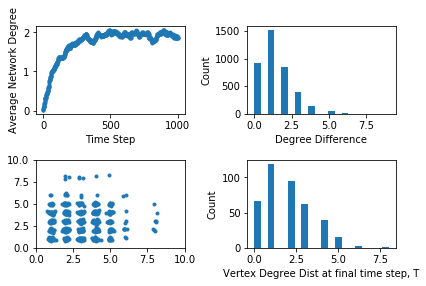

In [7]:
#random graph
mixing = "random"
generated_network = generate_network(n_males, n_females, d_m, p_f, p_d, T, mixing)
n_edges = generated_network[1]
deg_diffs = generated_network[2]
G_random = generated_network[0]
make_plots(n_edges, n_males, n_females, deg_diffs, T, G_random, d_m)

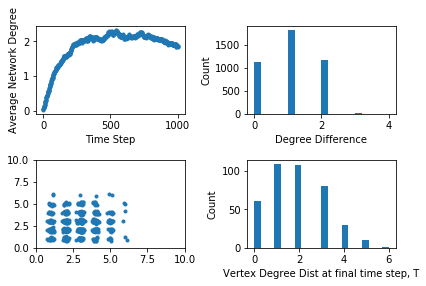

In [8]:
##assortative graph
mixing = "assort"
generated_network = generate_network(n_males, n_females, d_m, p_f, p_d, T, mixing)
n_edges = generated_network[1]
deg_diffs = generated_network[2]
G_assort = generated_network[0]
make_plots(n_edges, n_males, n_females, deg_diffs, T, G_assort, d_m)

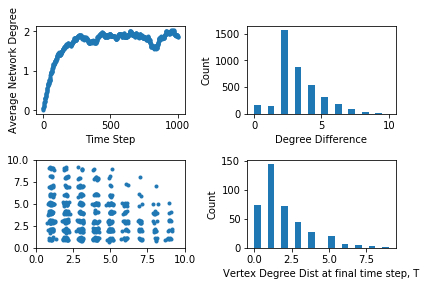

In [9]:
#dissassortative graph
mixing = "disassort"
generated_network = generate_network(n_males, n_females, d_m, p_f, p_d, T, mixing)
n_edges = generated_network[1]
deg_diffs = generated_network[2]
G_disassort = generated_network[0]
make_plots(n_edges, n_males, n_females, deg_diffs, T, G_disassort, d_m)

### (i) Does the average degree appear to saturate by the end of the simulation
    
   Yes, when looking at the average network degree for each type of graph, the average degree plateaus around 2 (with some fluctuation). While each type of graph reaches this saturation at slightly different timesteps, and deviate slightly depending on the timestep (and due to randomization), they all seem to reach saturation. The saturation makes sense since connections increase with each timestep. It also makes sense due to the constraints of the graphs being created. 
    
### (ii) Does the degree-degree scatter plot reflect the type of tie formation mechanism that was used to construct the network 

   Yes, the degree-degree scatter plot reflects the mechanism for each. For the random graph, the ties were constrained to form with only unconnected nodes, with each having a degree < d_m. So, since 10 is the maximum degree allowed for any node in the network, the degree-degree plot has values close to (10,10), but very few since it would be difficult to pick two random nodes that have say, have a high degree (like 7) and are not connected, because if you have a high degree, you're more likely to have an edge between you. 
    
   For the assortative graph, the ties were constrained to only unconnected nodes, with degree < 10, and an absolute difference in degree less than 2. Essentially, the degrees tended to be slightly clustered and have less variability. 

   For the disassortative graph, the ties were constrained to only unconnected nodes, with degree < 10, and an absolute difference in degree greater than 2. It's almost as if the constraint being put on the nodes pushes these values to the boundaries of the graph. Ths scatterplot has a higher variance than the other two networks, and is more spread out. 

### (iii) Is the histogram of deg_diffs values consistent with model specification? For example, for the dissassortative case, degree difference is allowed to have values 0, 1 and 2. There may however be a non-zero probability on slightly higher values.

   Yes, they do. For the random graph, there's a large variance in degree difference, as there was no constraint for this, and it's right skewed. For the assortative graph, as indicated, the degree differences are only 0, 1 or 2, with ocassionally some higher (since there's a non-zero chance of this). The slightly higher values make sense, since 100 edges were formed with random mixing. And finally, for the disasortative, the majority of the degree differences are at least 2, and there are differences as high as 9 shown on the histogram. The differences of 0 and 1 could be due to edges formed during the random tie formation. 



## Question 5: Propagating epidemics on networks

In this final question, we will propagate an SIR process on the three different networks we generated above. As the first step, extract the largest connected component (LCC) of each network and run all spreading processes on these components rather than the whole network. Write code to run an SIR spreading process 1000 times for 100 time steps on each network LCC. Use 0.2 for the S -> I transition probability, 0.05 for the I -> R transition probability, and to initialize the process use 10 seed nodes. Keep track of the number of nodes in the R state at the end of each simulation (at time = 100), which can be interpreted as the size of the epidemic at this point in time. Print out the average number of R nodes at time = 100, where the average is computed over the 1000 spreading process realizations. You should be able to reuse the code from Lab 3 in this question. For better averaging, we should really generate different network realizations as well as use larger networks, but to simplify things and save computation time, we use three relatively small fixed networks for all simulations. How does assortativity or disassortativity influence the size of the epidemic? You can repeat network generation a few times and rerun the spreading process, although you don't need to document that here.

In [10]:
# Carry out the S -> I spreading process forone time step.
def spread(G, s_nodes , i_nodes , p):
    
    new_infections = set ()
    
    for node in i_nodes:
        if G.degree(node) > 0:
            neighbor = random.choice(list (G.neighbors(node)))
            if (neighbor in s_nodes) and (random.random() < p):
                new_infections.add(neighbor)
    for node in new_infections:
        i_nodes.append(node)
        s_nodes.remove(node)
    return new_infections

## carry out the I --> R recovery process for one time stpe

def recover(i_nodes, r_nodes, p):
    new_recoveries = []
    for node in i_nodes:
        if random.random() < p:
            new_recoveries.append(node)
            
    for node in new_recoveries:
        r_nodes.append(node)
        i_nodes.remove(node)
    return new_recoveries

In [11]:
# Simulate an epidemic:
def simulate(G, p_si, p_ir, num_seeds, num_time_steps):
    #initiatlize some objects
    r_at_100 = []
    i_nodes = random.sample(G.nodes(), num_seeds)
    s_nodes = list(set(G.nodes()) - set(i_nodes))
    r_nodes = []
    num_s_nodes = [len(s_nodes)]
    num_i_nodes = [len(i_nodes)]
    num_r_nodes = [len(r_nodes)]
    #loop over all time
    for step in range(1, num_time_steps): #start with 1 because already did the first time step
        new_recoveries = recover(i_nodes, r_nodes, p_ir)
        new_infections = spread(G, s_nodes, i_nodes, p_si)
        num_s_nodes.append(len(s_nodes))
        num_i_nodes.append(len(i_nodes))
        num_r_nodes.append(len(r_nodes))
        if step == 99:
            r_at_100.append(len(r_nodes))
        if len(i_nodes) == 0:
            break
    return (r_at_100)


In [12]:
#simulate from random graph
G_random_LCC = max(nx.connected_component_subgraphs(G_random), key=len)
r_list = []
for i in range(0, 1000):
    sim = simulate(G_random_LCC, 0.2, 0.05, 10, 100)
    r_list.extend(sim)

r_random = np.mean(r_list)
print(r_random)

76.6936026936


In [13]:
#simulate from assort graph
G_assort_LCC = max(nx.connected_component_subgraphs(G_assort), key=len)
r_list = []
for i in range(0, 1000):
    sim = simulate(G_assort_LCC, 0.2, 0.05, 10, 100)
    r_list.extend(sim)

r_assort = np.mean(r_list)
print(r_assort)

73.3384074941


In [14]:
#simulate from disassort graph
G_disassort_LCC = max(nx.connected_component_subgraphs(G_disassort), key=len)
r_list = []
for i in range(0, 1000):
    sim = simulate(G_disassort_LCC, 0.2, 0.05, 10, 100)
    r_list.extend(sim)

r_disassort = np.mean(r_list)
print(r_disassort)

76.7314285714


How does assortativity or disassortativity influence the size of the epidemic?

It's difficult to draw a final conclusion in this case, as the results vary depending on the instance you are running the simulation. After several attempts, I got assortative with more recovered nodes, yet there was an instance that the disassortative network had more recovered nodes. Doing some research, I found that epidemics tend to spread more quickly through assortative networks, yet the reach is further in a disassortative network (which makes sense since it has the biggest largest connected component of the 3 networks in the exercise). Again, while I got results that tended towards the assortative network, I think I would need to run this many more times to come to a final conclusion. (In the instance printed here, the recovered nodes for the random is 78, 87 for assortative, and 78 for disassortative).